This notebook was adapted from the demo for UrbanAccess provided by UrbanSim: https://github.com/UDST/urbanaccess

In [1]:
import matplotlib
matplotlib.use('agg')  # allows notebook to be tested in Travis

import pandas as pd
# import cartopy.crs as ccrs
# import cartopy
import matplotlib.pyplot as plt
import pandana as pdna
import time

import urbanaccess as ua
from urbanaccess.config import settings
from urbanaccess.gtfsfeeds import feeds
from urbanaccess import gtfsfeeds
from urbanaccess.gtfs.gtfsfeeds_dataframe import gtfsfeeds_dfs
from urbanaccess.network import ua_network, load_network

%matplotlib inline

The `settings` object is a global `urbanaccess_config` object that can be used to set default options in UrbanAccess. In general, these options do not need to be changed.

In [2]:
# Set default options in UrbanAccess

settings.to_dict()

{'data_folder': 'data',
 'logs_folder': 'logs',
 'log_file': True,
 'log_console': False,
 'log_name': 'urbanaccess',
 'log_filename': 'urbanaccess',
 'txt_encoding': 'utf-8',
 'gtfs_api': {'gtfsdataexch': 'http://www.gtfs-data-exchange.com/api/agencies?format=csv'}}

## Build Transit Network

In [3]:
# Create a feeds object for storing GTFS feeds

feeds.to_dict()

{'gtfs_feeds': {}}

In [4]:
# Search for and add the BART GTFS feed.

gtfsfeeds.search(search_text='Bay Area Rapid Transit',
                 search_field=None,
                 match='contains',
                 add_feed=True)

Note: Your use of a GTFS feed is governed by each GTFS feed author license terms. It is suggested you read the respective license terms for the appropriate use of a GTFS feed.
Found 1 records that matched ['Bay Area Rapid Transit'] inside ['name', 'url', 'dataexchange_id', 'feed_baseurl'] columns:
Added 1 feeds to gtfs_feeds: {'Bay Area Rapid Transit': 'http://www.gtfs-data-exchange.com/agency/bay-area-rapid-transit/latest.zip'}
Added 1 records to gtfs_feed list:


{'Bay Area Rapid Transit': 'http://www.gtfs-data-exchange.com/agency/bay-area-rapid-transit/latest.zip'}

In [5]:
# Add the AC Transit GTFS feed (as of 2017)

feeds.add_feed(add_dict={'ac transit': 'http://www.actransit.org/wp-content/uploads/GTFSJune182017B.zip'})

Added 1 feeds to gtfs_feeds: {'ac transit': 'http://www.actransit.org/wp-content/uploads/GTFSJune182017B.zip'}


In [6]:
# Check to make sure the feeds have been added properly

feeds.to_dict()

{'gtfs_feeds': {'Bay Area Rapid Transit': 'http://www.gtfs-data-exchange.com/agency/bay-area-rapid-transit/latest.zip',
  'ac transit': 'http://www.actransit.org/wp-content/uploads/GTFSJune182017B.zip'}}

In [7]:
# Download the feeds into the data folder

gtfsfeeds.download()

2 GTFS feed(s) will be downloaded here: data/gtfsfeed_zips
Bay Area Rapid Transit GTFS feed downloaded successfully. Took 1.77 seconds for 343,657.0KB
ac transit GTFS feed downloaded successfully. Took 2.06 seconds for 11,468,341.0KB
GTFS feed download completed. Took 3.83 seconds
ac transit.zip successfully extracted to: data/gtfsfeed_text/ac transit
Bay Area Rapid Transit.zip successfully extracted to: data/gtfsfeed_text/Bay Area Rapid Transit
GTFS feed zipfile extraction completed. Took 0.16 seconds for 2 files


Now that we have downloaded our data let's load our individual GTFS feeds (currently a series of text files stored on disk) into a combined network of Pandas DataFrames.

- You can specify one feed or multiple feeds that are inside a root folder using the `gtfsfeed_path` parameter. If you want to aggregate multiple transit networks together, all the GTFS feeds you want to aggregate must be inside of a single root folder.
- Turn on `validation` and set a bounding box with the `remove_stops_outsidebbox` parameter turned on to ensure all your GTFS feed data are within a specified area.

Let's specify a bounding box of coordinates for the City of Oakland to subset the GTFS data to. You can generate a bounding box by going to http://boundingbox.klokantech.com/ and selecting the CSV format.

In [8]:
# Set the bounding box for the area of study (City of Oakland)

oak_bbox = (-122.355881,37.632226,-122.114775,37.884725)

In [9]:
# Load the transit data into a collection of DataFrames

loaded_feeds = ua.gtfs.load.gtfsfeed_to_df(gtfsfeed_path= None,
                                           validation= True,
                                           verbose= True,
                                           bbox= oak_bbox,
                                           remove_stops_outsidebbox = True,
                                           append_definitions= True)

Checking GTFS text file header whitespace... Reading files using encoding: utf-8 set in configuration.
GTFS text file header whitespace check completed. Took 0.16 seconds
--------------------------------
Processing GTFS feed: ac transit
The unique agency id: ac_transit was generated using the name of the agency in the agency.txt file.
Unique agency id operation complete. Took 0.03 seconds
Unique GTFS feed id operation complete. Took 0.00 seconds
Records:
         stop_id                         stop_name   stop_lat    stop_lon  \
195      0200010       Bayside Common Condominiums  37.896314 -122.308150   
196      0200030            Buchanan St:Jackson St  37.887757 -122.300790   
197      0200040            Buchanan St:Jackson St  37.887509 -122.301187   
198      0200050             Buchanan St:Pierce St  37.887582 -122.305140   
199      0200060               Buchanan St:Polk St  37.887683 -122.302584   
...          ...                               ...        ...         ...   
49

### The transit data object

The output is a global `urbanaccess_gtfs_df` object that can be accessed with the specified variable `loaded_feeds`. This object holds all the individual GTFS feed files aggregated together with each GTFS feed file type in separate Pandas DataFrames to represent all the loaded transit feeds in a metropolitan area. 

In [10]:
loaded_feeds.stops.head()

,stop_id,stop_name,stop_lat,stop_lon,stop_code,location_type,parent_station,unique_agency_id,unique_feed_id,route_type,stop_desc,zone_id,stop_url,stop_timezone,wheelchair_boarding,location_type_desc,wheelchair_boarding_desc
0,0100060,8th St:Portola Av,37.768814,-122.272992,52246.0,NaN,NaN,ac_transit,ac_transit_1,3.0,NaN,NaN,NaN,NaN,NaN,None,None
1,0100070,8th St:Portola Av,37.768993,-122.272798,57793.0,NaN,NaN,ac_transit,ac_transit_1,3.0,NaN,NaN,NaN,NaN,NaN,None,None
2,0100110,Atlantic Av:#1105,37.780272,-122.264015,56707.0,NaN,NaN,ac_transit,ac_transit_1,3.0,NaN,NaN,NaN,NaN,NaN,None,None
3,0100170,Atlantic Av:Challenger Dr,37.781066,-122.270060,57796.0,NaN,NaN,ac_transit,ac_transit_1,3.0,NaN,NaN,NaN,NaN,NaN,None,None
4,0100180,Atlantic Av:Constitution Way,37.779879,-122.275281,50101.0,NaN,NaN,ac_transit,ac_transit_1,3.0,NaN,NaN,NaN,NaN,NaN,None,None


Note the two transit services we have aggregated into one regional table

In [11]:
loaded_feeds.stops.unique_agency_id.unique()

array(['ac_transit', 'bay_area_rapid_transit'], dtype=object)

Quickly view the transit stop locations

<AxesSubplot:xlabel='stop_lon', ylabel='stop_lat'>

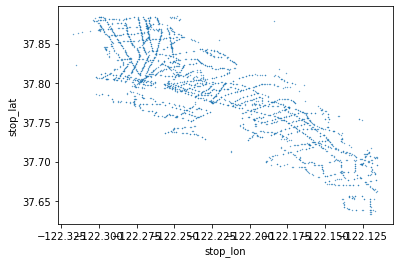

In [12]:
loaded_feeds.stops.plot(kind='scatter', x='stop_lon', y='stop_lat', s=0.1)

In [13]:
loaded_feeds.routes.head()

,agency_id,route_id,route_short_name,route_long_name,route_type,unique_agency_id,unique_feed_id,route_desc,route_url,route_color,route_text_color,route_type_desc
0,AC Transit,1-141,1,San Leandro Bart- Dtn. Oakland,3,ac_transit,ac_transit_1,NaN,NaN,NaN,NaN,Bus
1,AC Transit,10-141,10,San Leandro BART - Hayward BART,3,ac_transit,ac_transit_1,NaN,NaN,NaN,NaN,Bus
2,AC Transit,12-141,12,Dtn. Oakland /Dtn. Berkeley/4th St. Harrison,3,ac_transit,ac_transit_1,NaN,NaN,NaN,NaN,Bus
3,AC Transit,14-141,14,W.OAKLAND/FRUITVALE BART,3,ac_transit,ac_transit_1,NaN,NaN,NaN,NaN,Bus
4,AC Transit,18-141,18,San Pablo & Monroe/Berkeley/Merritt BART,3,ac_transit,ac_transit_1,NaN,NaN,NaN,NaN,Bus


In [14]:
loaded_feeds.stop_times.head()

,trip_id,stop_id,arrival_time,departure_time,stop_sequence,pickup_type,drop_off_type,unique_agency_id,unique_feed_id,route_type,stop_headsign,shape_dist_traveled,timepoint,pickup_type_desc,drop_off_type_desc,timepoint_desc,departure_time_sec
0,5458754-1706SU-D4-Saturday-01,1009500,06:05:00,06:05:00,1,NaN,NaN,ac_transit,ac_transit_1,3,NaN,NaN,NaN,None,None,None,21900.0
1,5458754-1706SU-D4-Saturday-01,1007030,06:08:00,06:08:00,2,NaN,NaN,ac_transit,ac_transit_1,3,NaN,NaN,NaN,None,None,None,22080.0
2,5458754-1706SU-D4-Saturday-01,1015180,NaN,,3,NaN,NaN,ac_transit,ac_transit_1,3,NaN,NaN,NaN,None,None,None,NaN
3,5458754-1706SU-D4-Saturday-01,1015000,NaN,,4,NaN,NaN,ac_transit,ac_transit_1,3,NaN,NaN,NaN,None,None,None,NaN
4,5458754-1706SU-D4-Saturday-01,1014390,NaN,,5,NaN,NaN,ac_transit,ac_transit_1,3,NaN,NaN,NaN,None,None,None,NaN


In [15]:
loaded_feeds.trips.head()

,route_id,trip_id,service_id,trip_headsign,direction_id,block_id,shape_id,unique_agency_id,unique_feed_id,wheelchair_accessible,bikes_allowed,bikes_allowed_desc,wheelchair_accessible_desc
0,NL-141,5458754-1706SU-D4-Saturday-01,1706SU-D4-Saturday-01,NL SAN FRANCISCO,1,770875.0,NL0006,ac_transit,ac_transit_1,NaN,NaN,None,None
1,NL-141,5458755-1706SU-D4-Saturday-01,1706SU-D4-Saturday-01,NL SAN FRANCISCO,1,770873.0,NL0006,ac_transit,ac_transit_1,NaN,NaN,None,None
2,NL-141,5458756-1706SU-D4-Saturday-01,1706SU-D4-Saturday-01,NL SAN FRANCISCO,1,770857.0,NL0006,ac_transit,ac_transit_1,NaN,NaN,None,None
3,NL-141,5458757-1706SU-D4-Saturday-01,1706SU-D4-Saturday-01,NL SAN FRANCISCO,1,770857.0,NL0006,ac_transit,ac_transit_1,NaN,NaN,None,None
4,NL-141,5458758-1706SU-D4-Saturday-01,1706SU-D4-Saturday-01,NL SAN FRANCISCO,1,770875.0,NL0006,ac_transit,ac_transit_1,NaN,NaN,None,None


In [16]:
loaded_feeds.calendar.head()

,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date,unique_agency_id,unique_feed_id
0,1706SU-D2-Saturday-02,0,0,0,0,0,1,0,20170624,20170819,ac_transit,ac_transit_1
1,1706SU-D2-Sunday-02,0,0,0,0,0,0,1,20170618,20170813,ac_transit,ac_transit_1
2,1706SU-D2-Weekday-20,1,1,1,1,1,0,0,20170619,20170818,ac_transit,ac_transit_1
3,1706SU-D2-Weekday-20-0000100,0,0,0,0,1,0,0,20170619,20170818,ac_transit,ac_transit_1
4,1706SU-D3-Weekday-20,1,1,1,1,1,0,0,20170619,20170818,ac_transit,ac_transit_1


In [17]:
# Set the bbox for the study area (City of Oakland)

oak_bbox = (-122.355881,37.632226,-122.114775,37.884725)

In [18]:
# Load the transit data into a collection of DataFrames

loaded_feeds = ua.gtfs.load.gtfsfeed_to_df(gtfsfeed_path=None,
                                           validation= True,
                                           verbose= True,
                                           bbox= oak_bbox,
                                           remove_stops_outsidebbox=True,
                                           append_definitions=True)

Checking GTFS text file header whitespace... Reading files using encoding: utf-8 set in configuration.
GTFS text file header whitespace check completed. Took 0.15 seconds
--------------------------------
Processing GTFS feed: ac transit
The unique agency id: ac_transit was generated using the name of the agency in the agency.txt file.
Unique agency id operation complete. Took 0.03 seconds
Unique GTFS feed id operation complete. Took 0.00 seconds
Records:
         stop_id                         stop_name   stop_lat    stop_lon  \
195      0200010       Bayside Common Condominiums  37.896314 -122.308150   
196      0200030            Buchanan St:Jackson St  37.887757 -122.300790   
197      0200040            Buchanan St:Jackson St  37.887509 -122.301187   
198      0200050             Buchanan St:Pierce St  37.887582 -122.305140   
199      0200060               Buchanan St:Polk St  37.887683 -122.302584   
...          ...                               ...        ...         ...   
49

In [19]:
# Create a travel-time-weighted transit network from the GTFS feeds.
# Specify the network for midday on a saturday when people are likely to visit parks.

ua.gtfs.network.create_transit_net(gtfsfeeds_dfs=loaded_feeds,
                                   day='saturday',
                                   timerange=['11:00:00', '14:00:00'],
                                   calendar_dates_lookup=None)

Using calendar to extract service_ids to select trips.
6 service_ids were extracted from calendar
5,145 trip(s) 29.26 percent of 17,582 total trip records were found in calendar for GTFS feed(s): ['ac transit', 'bay area rapid transit']
NOTE: If you expected more trips to have been extracted and your GTFS feed(s) have a calendar_dates file, consider utilizing the calendar_dates_lookup parameter in order to add additional trips based on information inside of calendar_dates. This should only be done if you know the corresponding GTFS feed is using calendar_dates instead of calendar to specify service_ids. When in doubt do not use the calendar_dates_lookup parameter.
5,145 of 17,582 total trips were extracted representing calendar day: saturday. Took 0.03 seconds
Note: Processing may take a long time depending on the number of records. Total unique trips to assess: 4,380
Starting departure stop time interpolation...
Departure time records missing from trips following the specified schedul

In [20]:
# Calculate route stop level average headways 
# to approximate passenger wait times at stops and stations.

ua.gtfs.headways.headways(gtfsfeeds_df=loaded_feeds,
                          headway_timerange=['11:00:00','14:00:00'])

Stop times from 11:00:00 to 14:00:00 successfully selected 23,159 records out of 137,788 total records (16.81 percent of total). Took 0.00 seconds
Starting route stop headway calculation for 3,067 route stops...
Route stop headway calculation complete. Took 4.07 seconds
headway calculation complete. Took 4.28 seconds


In [21]:
# Save the transit network to a variable

urbanaccess_net = ua.network.ua_network

<AxesSubplot:xlabel='x', ylabel='y'>

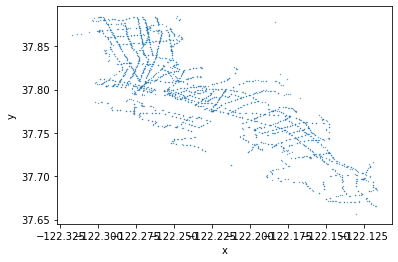

In [22]:
# Visualize the transit network

urbanaccess_net.transit_nodes.plot(kind='scatter', x='x', y='y', s=0.1)

## Build Pedestrian Network

In [23]:
# Download OSM pedestrian street network data

nodes, edges = ua.osm.load.ua_network_from_bbox(bbox= oak_bbox,
                                                remove_lcn=True)

Requesting network data within bounding box from Overpass API in 1 request(s)
Posting to http://www.overpass-api.de/api/interpreter with timeout=180, "{'data': '[out:json][timeout:180];(way["highway"]["highway"!~"motor|proposed|construction|abandoned|platform|raceway"]["foot"!~"no"]["pedestrians"!~"no"](37.63222600,-122.35588100,37.88472500,-122.11477500);>;);out;'}"
Downloaded 37,140.2KB from www.overpass-api.de in 6.12 seconds
Downloaded OSM network data within bounding box from Overpass API in 1 request(s) and 6.84 seconds
Returning OSM data with 230,228 nodes and 47,688 ways...
Edge node pairs completed. Took 35.99 seconds
Returning processed graph with 59,537 nodes and 166,602 edges...
Completed OSM data download and Pandana node and edge table creation in 45.65 seconds
checking for low connectivity nodes...
Generating contraction hierarchies with 12 threads.
Setting CH node vector of size 59537
Setting CH edge vector of size 172430
Range graph removed 181138 edges of 344860
. 10%

In [24]:
# Create a travel-time-weighted pedestrian network.
# It is automatically added to the same variable as the transit network

ua.osm.network.create_osm_net(osm_edges=edges,
                              osm_nodes=nodes,
                              travel_speed_mph=3)

Created OSM network with travel time impedance using a travel speed of 3 MPH. Took 0.00 seconds


<AxesSubplot:xlabel='x', ylabel='y'>

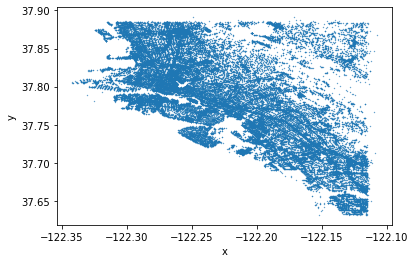

In [25]:
# Visualize the pedestrian network

urbanaccess_net.osm_nodes.plot(kind='scatter', x='x', y='y', s=0.1)

## Integrate Transit + Pedestrian Networks

In [26]:
# Integrate the networks (still in our urbanaccess_net variable)

ua.network.integrate_network(urbanaccess_network=urbanaccess_net,
                             headways=True,
                             urbanaccess_gtfsfeeds_df=loaded_feeds,
                             headway_statistic='mean')

Loaded UrbanAccess network components comprised of:
     Transit: 2,309 nodes and 22,269 edges;
     OSM: 59,491 nodes and 166,502 edges
routes successfully joined to transit nodes. Took 0.04 seconds
Connector edges between the OSM and transit network nodes successfully completed. Took 1.01 seconds
mean route stop headway will be used for pedestrian to transit edge impedance.
Headway impedance calculation completed. Took 0.01 seconds
Edge and node tables formatted for Pandana with integer node ids: id_int, to_int, and from_int. Took 1.83 seconds
Network edge and node network integration completed successfully resulting in a total of 62,553 nodes and 214,963 edges:
     Transit: 3,062 nodes 22,269 edges;
     OSM: 59,491 nodes 166,502 edges; and
     OSM/Transit connector: 26,192 edges.


Figure created. Took 13.35 seconds


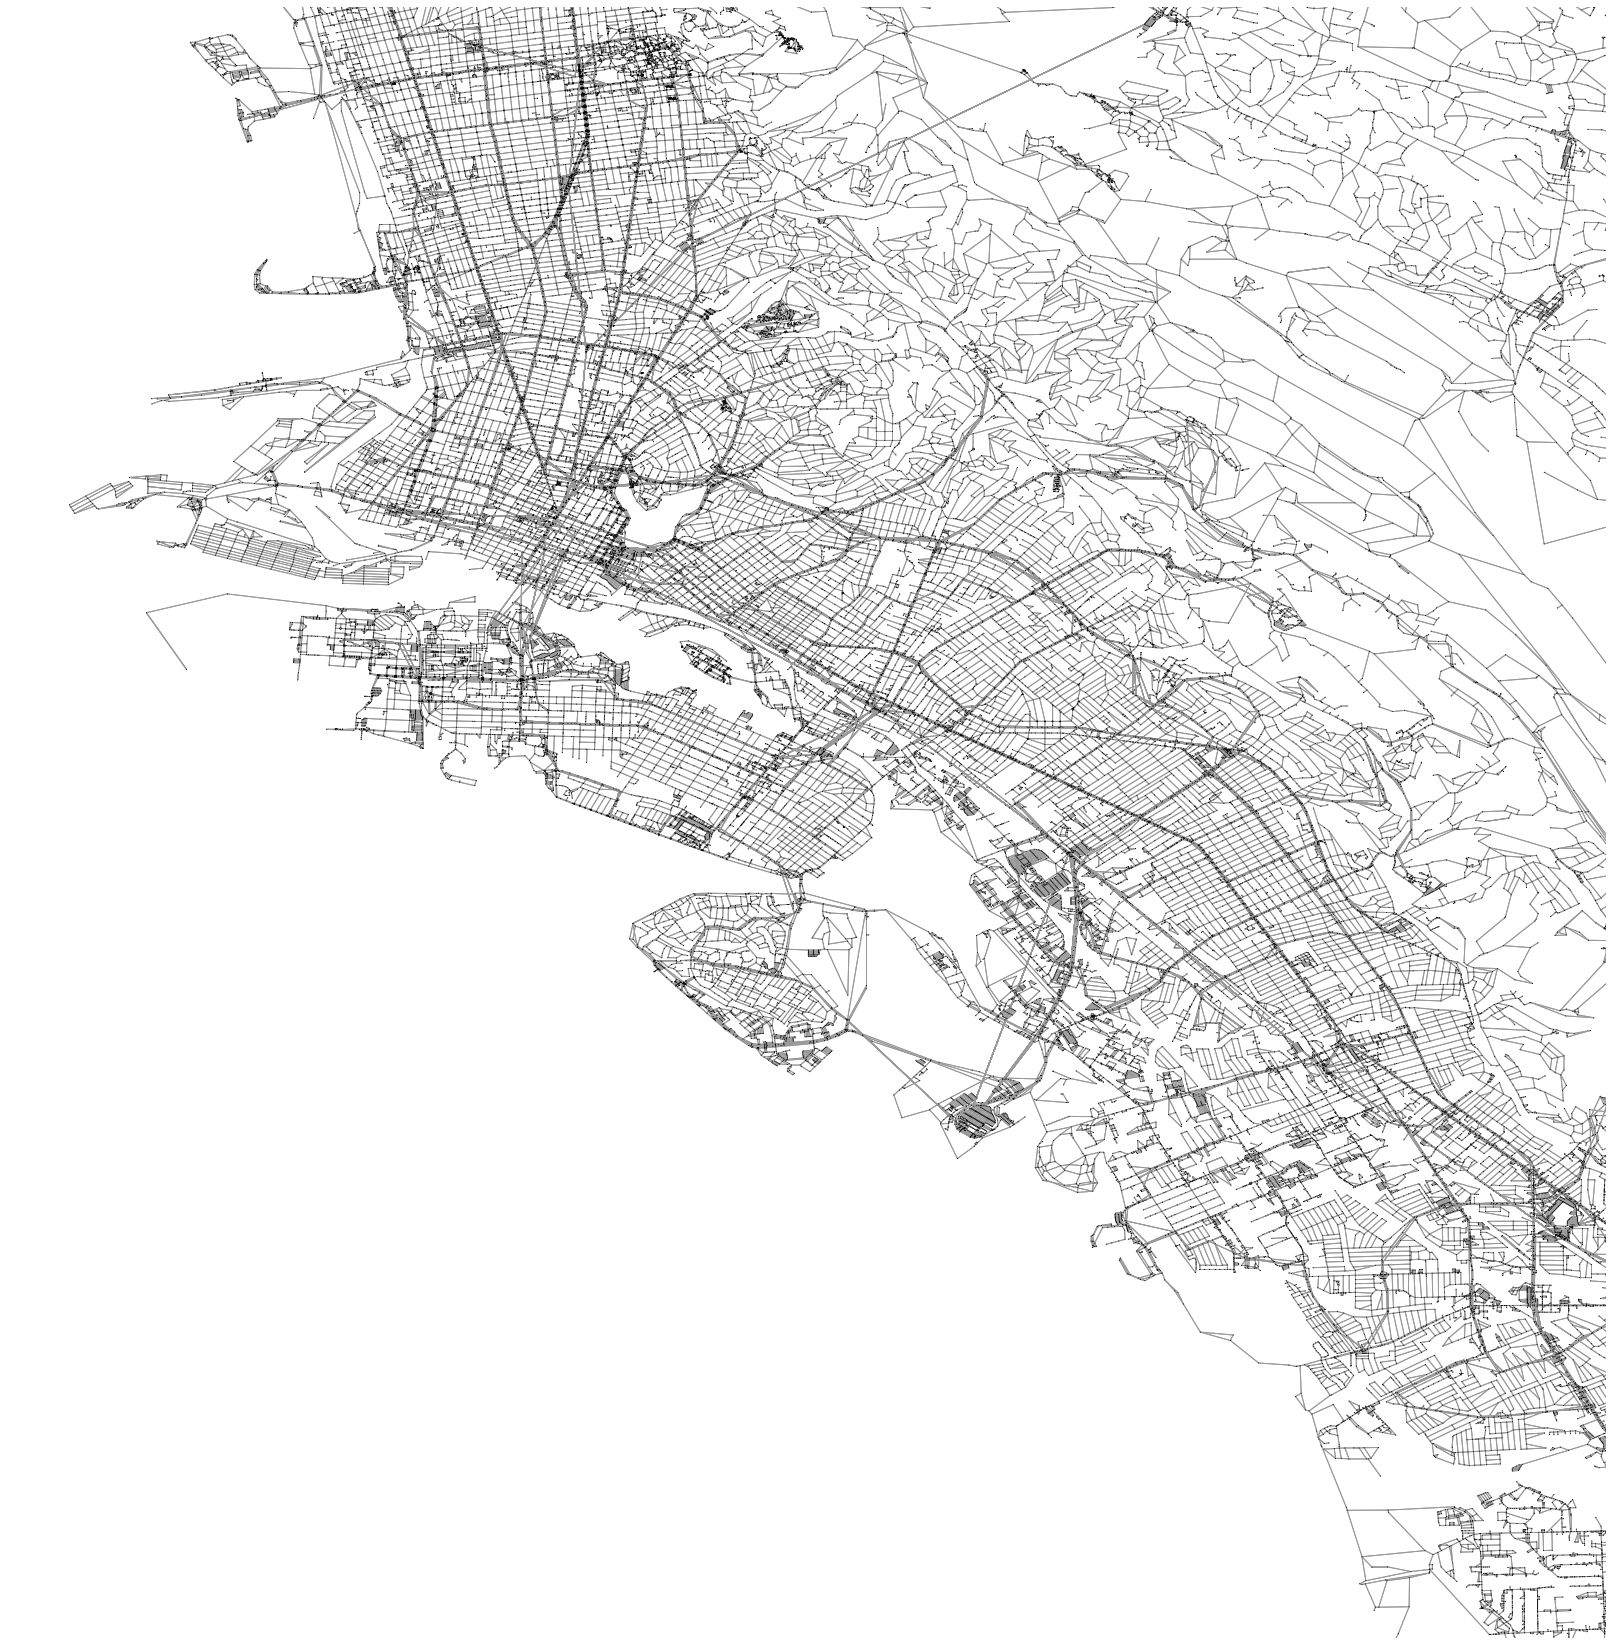

(<Figure size 2062.54x2160 with 1 Axes>, <AxesSubplot:>)

In [27]:
# Visualize the integrated network

ua.plot.plot_net(nodes=urbanaccess_net.net_nodes,
                 edges=urbanaccess_net.net_edges,
                 bbox=oak_bbox,
                 fig_height=30, margin=0.02,
                 edge_color='#999999', edge_linewidth=1, edge_alpha=1,
                 node_color='black', node_size=1.1, node_alpha=1, node_edgecolor='none', node_zorder=3, nodes_only=False)

In [28]:
# Save the network as an HDF5 file

ua.network.save_network(urbanaccess_network=urbanaccess_net,
                        filename='final_net.h5',
                        overwrite_key = True)

Using existing data/final_net.h5 hdf5 store.
Existing edges overwritten in data/final_net.h5 hdf5 store.
Using existing data/final_net.h5 hdf5 store.
Existing nodes overwritten in data/final_net.h5 hdf5 store.


In [29]:
# Load the saved network from file

urbanaccess_net = ua.network.load_network(filename='final_net.h5')

Successfully read store: data/final_net.h5 with the following keys: ['/edges', '/nodes']
Successfully read store: data/final_net.h5 with the following keys: ['/edges', '/nodes']


# STOPPED HERE

# Using an UrbanAccess network with Pandana

Pandana (Pandas Network Analysis) is a tool to compute network accessibility metrics.

Now that we have an integrated transit and pedestrian network that has been formatted for use with Pandana, we can now use Pandana right away to compute accessibility metrics.

There are a couple of things to remember about UrbanAccess and Pandana:
- UrbanAccess generates by default a one way network. One way means there is an explicit edge for each direction in the edge table. Where applicable, it is important to set any Pandana `two_way` parameters to `False` (they are `True` by default) to indicate that the network is a one way network.
- As of Pandana v0.3.0, `node ids` and `from` and `to` columns in your network must be integer type and not string. UrbanAccess automatically generates both string and integer types so use the `from_int` and `to_int` columns in edges and the index in nodes `id_int`.
- UrbanAccess by default will generate edge weights that represent travel time in units of minutes.

For more on Pandana see the:

**Pandana repo:** https://github.com/UDST/pandana 

**Pandana documentation:** http://udst.github.io/pandana/

## Load Census block data

Let's load 2010 Census block data for the 9 county Bay Area. Note: These data have been processed from original Census and LEHD data.

The data is located in the `demo` folder on the repo with this notebook.

In [ ]:
blocks = pd.read_hdf('bay_area_demo_data.h5','blocks')
# remove blocks that contain all water
blocks = blocks[blocks['square_meters_land'] != 0]
print('Total number of blocks: {:,}'.format(len(blocks)))
blocks.head()

Let's subset the Census data to just be the bounding box for Oakland

In [ ]:
lng_max, lat_min, lng_min, lat_max = bbox
outside_bbox = blocks.loc[~(((lng_max < blocks["x"]) & (blocks["x"] < lng_min)) & ((lat_min < blocks["y"]) & (blocks["y"] < lat_max)))]
blocks_subset = blocks.drop(outside_bbox.index)
print('Total number of subset blocks: {:,}'.format(len(blocks_subset)))

In [ ]:
blocks_subset.plot(kind='scatter', x='x', y='y', s=0.1)

## Initialize the Pandana network

Let's initialize our Pandana network object using our transit and pedestrian network we created. Note: the `from_int` and `to_int` as well as the `twoway=False` denoting this is a explicit one way network.

In [ ]:
s_time = time.time()
transit_ped_net = pdna.Network(urbanaccess_net.net_nodes["x"],
                               urbanaccess_net.net_nodes["y"],
                               urbanaccess_net.net_edges["from_int"],
                               urbanaccess_net.net_edges["to_int"],
                               urbanaccess_net.net_edges[["weight"]], 
                               twoway=False)
print('Took {:,.2f} seconds'.format(time.time() - s_time))

Now let's set our blocks on to the network

In [ ]:
blocks_subset['node_id'] = transit_ped_net.get_node_ids(blocks_subset['x'], blocks_subset['y'])

### Calculate cumulative accessibility

Now let's compute an accessibility metric, in this case a cumulative accessibility metric. See Pandana for other metrics that can be calculated. 

Let's set the block variables we want to use as our accessibly metric on the Pandana network. In this case let's use `jobs`

In [ ]:
blocks_subset["jobs"].describe()

In [ ]:
transit_ped_net.set(blocks_subset.node_id, variable = blocks_subset.jobs, name='jobs')

Now let's run an cumulative accessibility query using our network and the jobs variable for three different travel time thresholds: 15, 30, 45 minutes.

Note: Depending on network size, radius threshold, computer processing power, and whether or not you are using multiple cores the compute process may take some time.

In [ ]:
s_time = time.time()
jobs_45 = transit_ped_net.aggregate(45, type='sum', decay='linear', name='jobs')
jobs_30 = transit_ped_net.aggregate(30, type='sum', decay='linear', name='jobs')
jobs_15 = transit_ped_net.aggregate(15, type='sum', decay='linear', name='jobs')
print('Took {:,.2f} seconds'.format(time.time() - s_time))

Quickly visualize the accessibility query results. As expected, note that a travel time of 15 minutes results in a lower number of jobs accessible at each network node.

In [ ]:
print(jobs_45.head())
print(jobs_30.head())
print(jobs_15.head())

### Jobs accessible within 15 minutes

Note how the radius of the number of jobs accessible expands as the time threshold increases where high accessibility is indicated in dark red. You can easily see downtown Oakland has the highest accessibility due to a convergence of transit routes and because downtown is where the majority of jobs in the area are located. Other high accessibility areas are visible elsewhere directly adjacent to BART metro rail stations of West Oakland, Fruitvale, and Coliseum and AC Transit bus routes on the main arterial road corridors.

In [ ]:
s_time = time.time()

fig = plt.subplots(figsize=(20,20))

data_crs = ccrs.PlateCarree()
ax = plt.axes(projection=ccrs.epsg(26943))
ax.add_feature(cartopy.feature.GSHHSFeature(scale='full'), edgecolor='grey')

plt.scatter(transit_ped_net.nodes_df.x, transit_ped_net.nodes_df.y, 
            c=jobs_15, s=4, cmap='gist_heat_r', edgecolor='none', transform=data_crs)
cb = plt.colorbar()

print('Took {:,.2f} seconds'.format(time.time() - s_time))

### Jobs accessible within 30 minutes

In [ ]:
s_time = time.time()

fig = plt.subplots(figsize=(20,20))

data_crs = ccrs.PlateCarree()
ax = plt.axes(projection=ccrs.epsg(26943))
ax.add_feature(cartopy.feature.GSHHSFeature(scale='full'), edgecolor='grey')

plt.scatter(transit_ped_net.nodes_df.x, transit_ped_net.nodes_df.y, 
            c=jobs_30, s=4, cmap='gist_heat_r', edgecolor='none', transform=data_crs)
cb = plt.colorbar()

print('Took {:,.2f} seconds'.format(time.time() - s_time))

### Jobs accessible within 45 minutes

In [ ]:
s_time = time.time()

fig = plt.subplots(figsize=(20,20))

data_crs = ccrs.PlateCarree()
ax = plt.axes(projection=ccrs.epsg(26943))
ax.add_feature(cartopy.feature.GSHHSFeature(scale='full'), edgecolor='grey')

plt.scatter(transit_ped_net.nodes_df.x, transit_ped_net.nodes_df.y, 
            c=jobs_45, s=4, cmap='gist_heat_r', edgecolor='none', transform=data_crs)
cb = plt.colorbar()

print('Took {:,.2f} seconds'.format(time.time() - s_time))